In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr
import scipy.stats as stats
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr
import cloudpickle as pickle

sns.set_context("paper")
simHei = FontProperties(fname=r'/usr/share/fonts/Chinses/simhei.ttf', size=10) 
import warnings
warnings.filterwarnings('ignore')

# 1. Load dataset

In [2]:
asv_data = pd.read_csv('../data/Preprocess/rawdata_16S_abundance.tsv', index_col=0, sep='\t')
taxa_data = pd.read_csv('../data/Preprocess/rawdata_16S_taxa.tsv', index_col=0, sep='\t')

In [3]:
ko_data = pd.read_csv('../data/Microbiome/ko_metagenome_rela.tsv', index_col=0, sep='\t', skiprows=1)
ko_data.columns = [i.replace('-', '_') for i in ko_data.columns]
path_data = pd.read_csv('../data/Microbiome/pathway_abundance_rela.tsv', index_col=0, sep='\t', skiprows=1)
path_data.columns = [i.replace('-', '_') for i in path_data.columns]
ec_data = pd.read_csv('../data/Microbiome/ec_metagenome_rela.tsv', index_col=0, sep='\t', skiprows=1)
ec_data.columns = [i.replace('-', '_') for i in path_data.columns]
ko_data = ko_data.loc[:, asv_data.columns]
path_data = path_data.loc[:, asv_data.columns]
ec_data = ec_data.loc[:, asv_data.columns]
# Names
ko_names = pd.read_csv('../data/Microbiome/ko_info.tsv', index_col=0, sep='\t', header=None)
path_names = pd.read_csv('../data/Microbiome/metacyc_pathways_info.txt', index_col=0, sep='\t', header=None)
ec_names = pd.read_csv('../data/Microbiome/ec_level4_info.tsv', index_col=0, sep='\t', header=None)
path_anno = pd.read_csv('../data/Preprocess/MetaCYC_annotation.tsv', index_col=0, sep='\t')

# 2. Differential KOs and pathways

In [4]:
def diff_obj(data, names):
    from scipy.stats import fisher_exact, ranksums
    import statsmodels.stats.multitest as multi
    statistics = []
    for obj in data.index:
        row = []
        normal_abun = data.loc[obj, [i for i in data.columns if i[0]=='N']]
        pp_abun = data.loc[obj, [i for i in data.columns if i[0]=='P']]
        row.extend([names.loc[obj, 1] if obj in names.index else obj, normal_abun.mean(), pp_abun.mean()])
        f, p_value = ranksums(pp_abun, normal_abun)
        FC = pp_abun.mean()/normal_abun.mean() if normal_abun.mean()!=0 else np.inf
        row.extend([FC, p_value])
        statistics.append(row)
    statistics = pd.DataFrame(statistics, index = data.index, 
                             columns = ['Name','Normal_mean', 'PP_mean', 'FC','p_value'])
    statistics['FDR'] = multi.multipletests(statistics['p_value'], method = 'fdr_bh')[1]
    return statistics

In [5]:
path_statistics = diff_obj(path_data, path_names).sort_values(['FDR'])

In [6]:
anno_names = path_anno.loc[path_statistics.index, 'Annotation']
new_anno_names = []
for path in set(anno_names.index):
    if list(anno_names.index).count(path)>1:
        new_anno_names.append(sorted(anno_names[path], key=lambda x:len(x))[-1])
    else:
        new_anno_names.append(anno_names[path])
path_statistics['Name'] = new_anno_names

In [7]:
path_statistics.to_csv('Pathway/picrust_path.csv')

# Pathway Plot

In [37]:
path_statistics_diff = path_statistics.loc[path_statistics['FDR']<=0.05, :]
path_statistics_diff['Class'] = [i.split('L_3__')[1].split(';')[0] for i in path_statistics_diff['Name']]
path_statistics_diff['Last_name'] = [i.split('__')[-1] if '__' in i else i.strip() for i in path_statistics_diff['Name']]

In [154]:
path_statistics_diff.shape

(88, 9)

In [34]:
#path_statistics_diff.groupby('Class').size()
#path_statistics_diff.to_csv('Pathway/picrust_path_diff.csv')

In [39]:
path_statistics_diff = pd.read_csv('Pathway/picrust_path_diff.csv', index_col=0)
path_statistics_diff.head(2)

,Name,Normal_mean,PP_mean,FC,p_value,FDR,Last_name,Class,New_Class
#OTU ID,,,,,,,,,
PWY-6690,L_1__Pathways;L_2__Degradation/Utilization/Ass...,0.000100,0.000167,1.674304,2.010000e-06,4.180000e-05,superpathway of glycol metabolism and degradation,Alcohol Degradation,Others
PWY-6470,L_1__Pathways;L_2__Biosynthesis;L_3__Amino Aci...,0.000405,0.000147,0.363611,1.170000e-08,9.240000e-07,superpathway of branched chain amino acid bios...,Amino Acid Biosynthesis,Amino Acid


In [43]:
count = path_statistics_diff.groupby('New_Class').size()

In [42]:
groups = ['Amino Acid', 'Cofactor and Vitamin', 'Carbohydrate', 'Aromatic Compound', 
          'Fatty Acid and Lipid', 'Secondary Metabolite', 'Nucleoside and Nucleotide', 
          'Cell Structure', 'Inorganic Nutrient Metabolism', 'Polymeric Compound', 'Others']

In [45]:
count.loc[groups]/count.sum()

New_Class
Amino Acid                       0.193182
Cofactor and Vitamin             0.159091
Carbohydrate                     0.125000
Aromatic Compound                0.090909
Fatty Acid and Lipid             0.068182
Secondary Metabolite             0.068182
Nucleoside and Nucleotide        0.056818
Cell Structure                   0.056818
Inorganic Nutrient Metabolism    0.034091
Polymeric Compound               0.022727
Others                           0.125000
dtype: float64

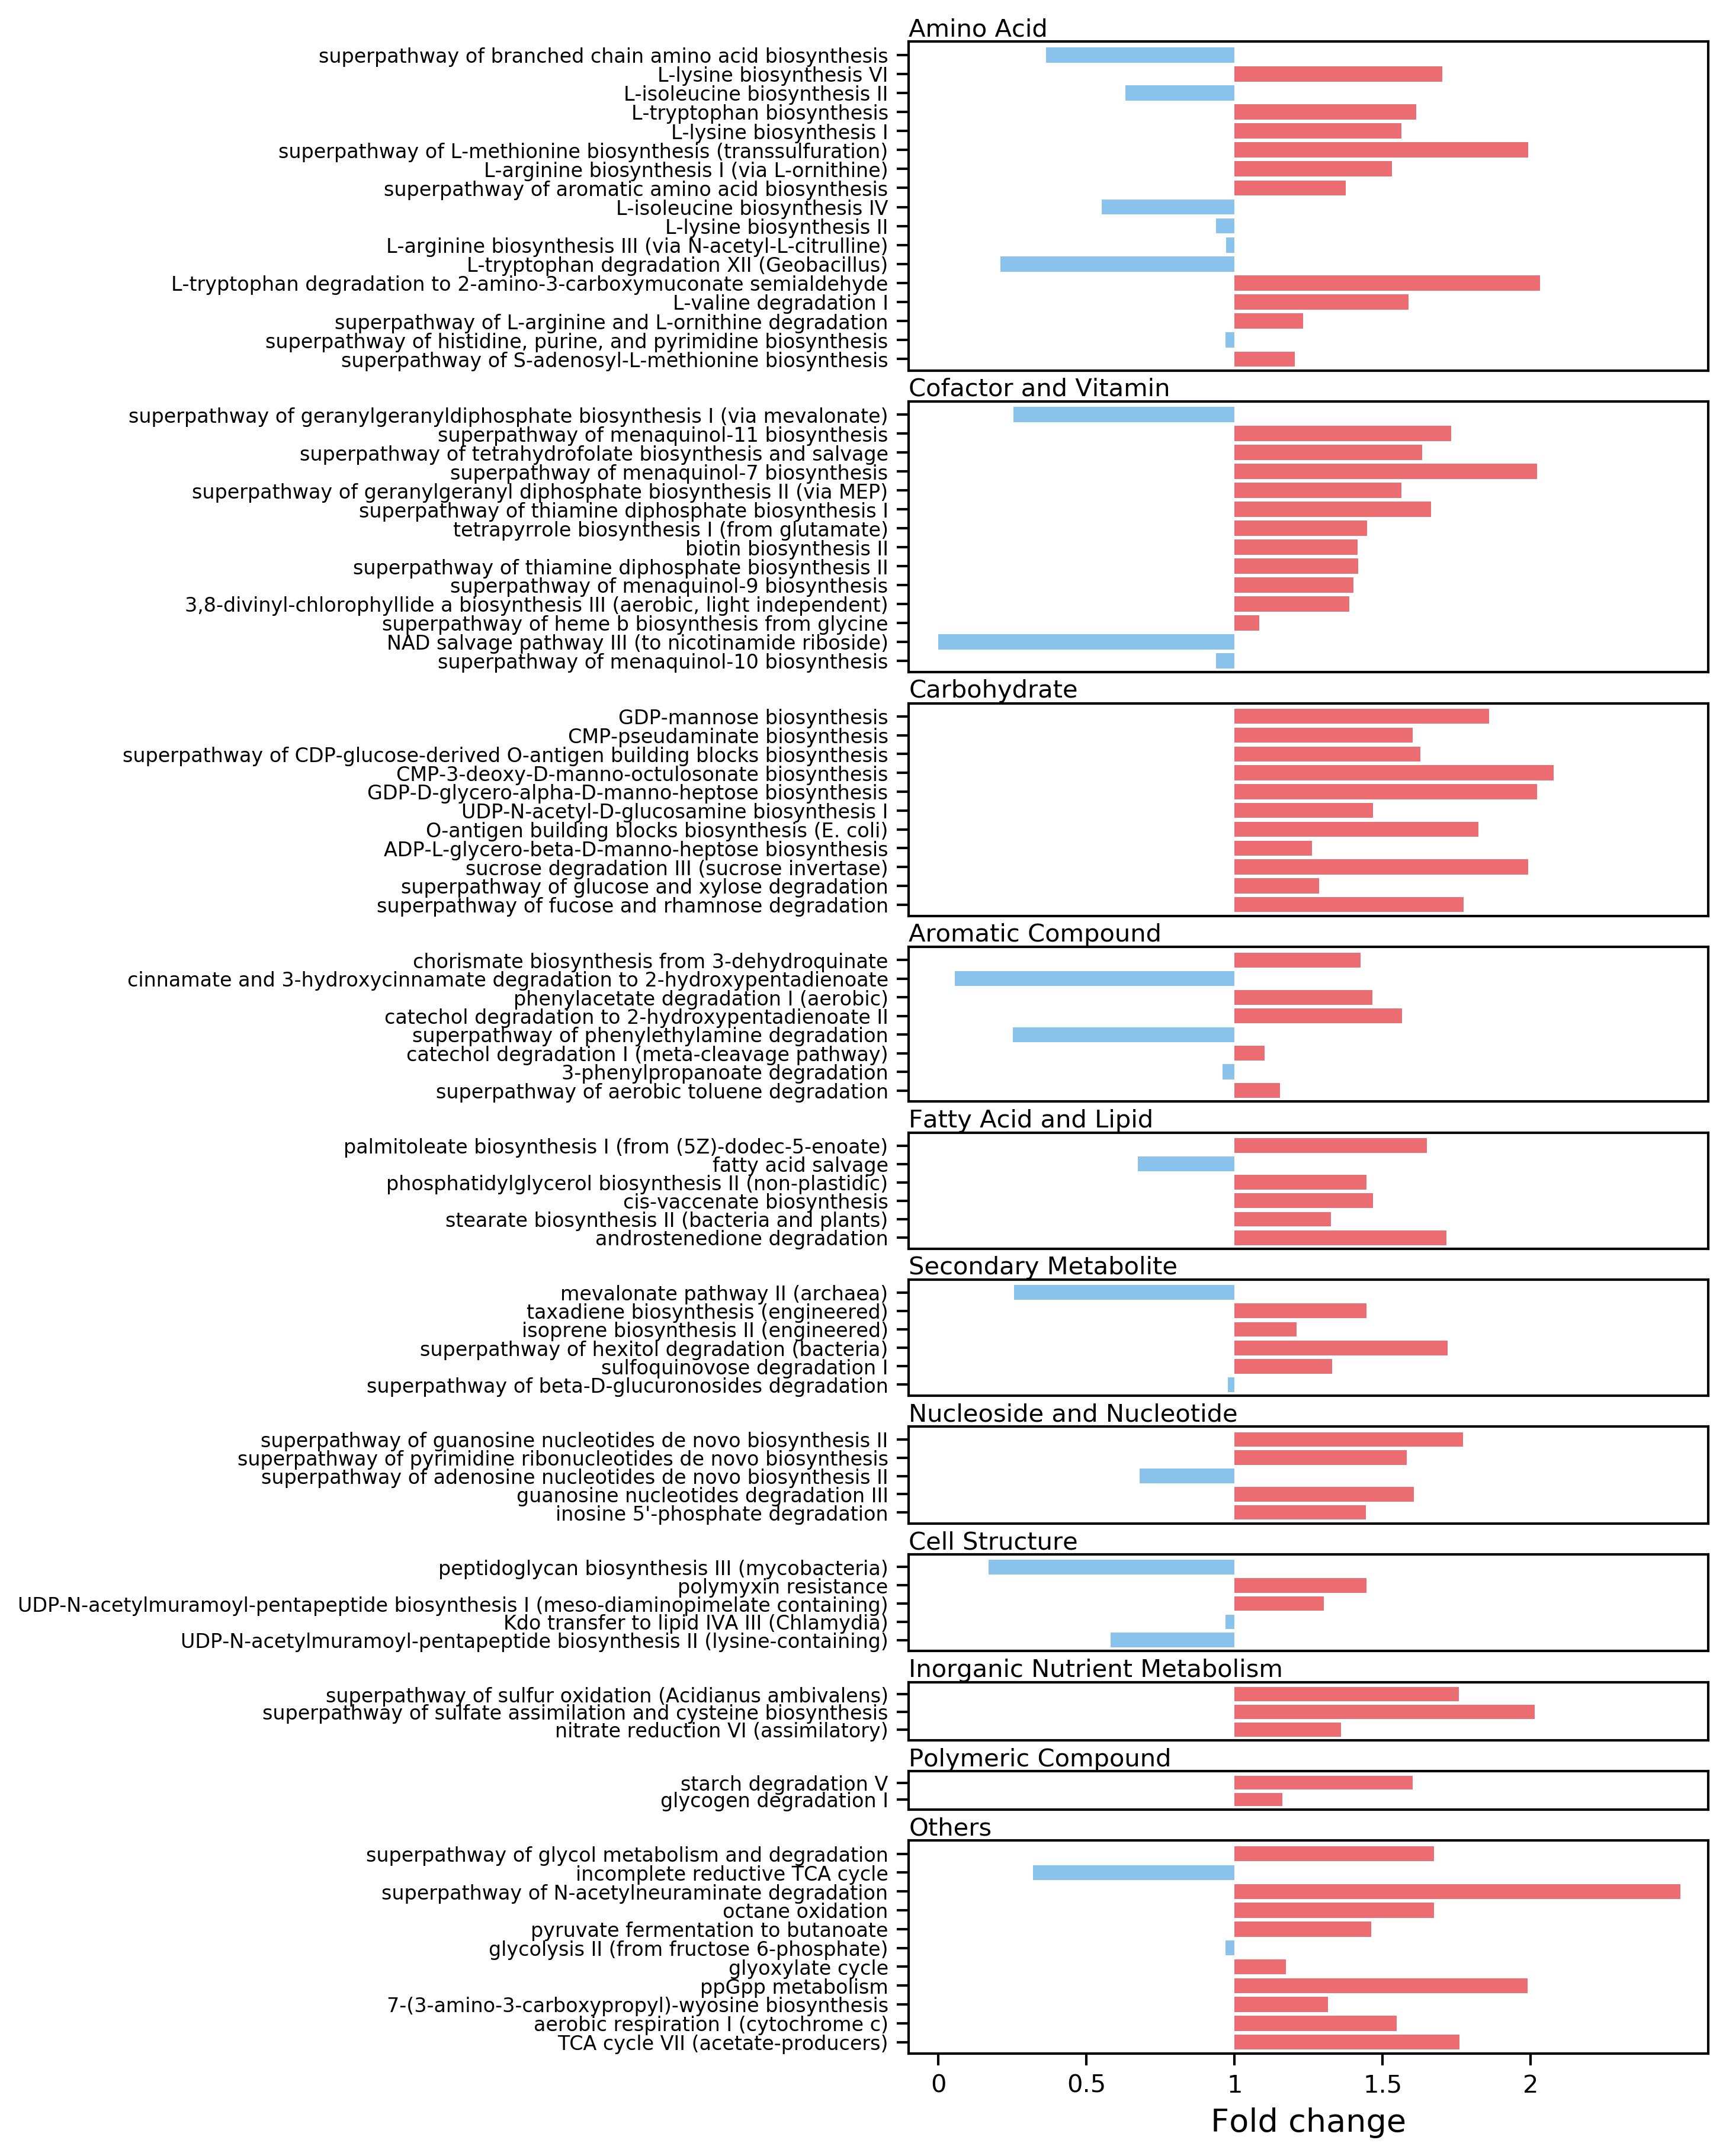

In [153]:
_ = plt.figure(figsize=(5, 15), dpi=300)
gs = gridspec.GridSpec(11, 1, height_ratios=list(count.loc[groups]/count.sum()))
gs.update(left=0.00, right=0.9, wspace=0.00, hspace=0.2)

for gi in range(len(groups)):
    group = groups[gi]
    ax = plt.subplot(gs[gi, 0])
    temp = path_statistics_diff.loc[path_statistics_diff['New_Class']==group, :]
    for i in range(temp.shape[0]):
        _ = ax.broken_barh([(0, temp['FC'][i]-1)], (temp.shape[0]-i-1.4, 0.8),
                           facecolors='#ec6d71' if temp['FC'][i]>1 else '#89c3eb')
    _ = plt.yticks(range(temp.shape[0])[::-1], temp['Last_name'], fontsize=8)
    _ = plt.ylim([-0.6, temp.shape[0]-0.3])
    _ = plt.annotate(group, (0, 0), (-1.1, temp.shape[0]), fontsize=10, rotation=0)
    _ = plt.xlim(-1.1, 1.6)
    _ = plt.xticks([])
_ = plt.xticks([-1, -0.5, 0, 0.5, 1], [0, 0.5, 1, 1.5, 2], fontsize=10)    
_ = plt.xlabel('Fold change', fontsize=13)
